In [1]:
import numpy as np
import torch

from simulation_study_helpers import *
from training_helpers import *
from nf_mctm import *
import mlflow

In [2]:
#experiment_id = mlflow.create_experiment(name="test_sim_study",artifact_location="/Users/maherp/Desktop/Universitaet/Goettingen/5_Semester/master_thesis/mctm_pytorch/mlflow_storage/test_sim_study/")
experiment_id = 1

In [3]:
seed_value = 1
penvalueridge = 0
penfirstridge = 0
pensecondridge = 0
poly_span_abs = 15
spline_decorrelation = "bspline"
iterations = 400
learning_rate = 0.5
patience = 5
min_delta = 1e-7
degree_transformations=10
degree_decorrelation=12
normalisation_layer=None

In [4]:
mlflow.start_run(
    run_name="{}".format(seed_value),
    experiment_id=experiment_id,
    tags={"seed": seed_value}
)

<ActiveRun: >

In [5]:
mlflow.log_param(key="seed",value=seed_value)
mlflow.log_param(key="pen_value_ridge", value=penvalueridge)
mlflow.log_param(key="pen_first_ridge", value=penfirstridge)
mlflow.log_param(key="pen_second_ridge", value=pensecondridge)
mlflow.log_param(key="poly_span_abs", value=poly_span_abs)
mlflow.log_param(key="spline_decorrelation", value=spline_decorrelation)
mlflow.log_param(key="iterations", value=iterations)
mlflow.log_param(key="learning_rate", value=learning_rate)
mlflow.log_param(key="patience", value=patience)
mlflow.log_param(key="min_delta", value=min_delta)
mlflow.log_param(key="degree_transformations", value=degree_transformations)
mlflow.log_param(key="degree_decorrelation", value=degree_decorrelation)
mlflow.log_param(key="normalisation_layer", value=normalisation_layer)

In [6]:
set_seeds(seed_value)
y_train, train_likelihood = create_data(2000)
y_test, test_likelihood  = create_uniform_test_grid(num_observations=2000,ci_border=0.99)

 51%|█████▏    | 205/400 [00:54<00:52,  3.74it/s]

Early Stop!


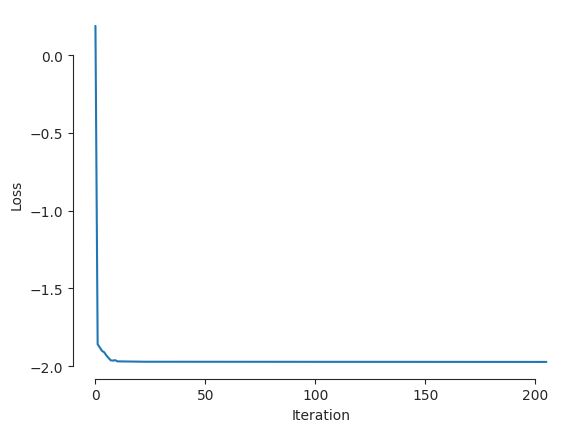

In [7]:
poly_range = torch.FloatTensor([[-poly_span_abs], [poly_span_abs]])
penalty_params = torch.tensor([penvalueridge,
                              penfirstridge,
                              pensecondridge])

nf_mctm = NF_MCTM(input_min=y_train.min(0).values,
                  input_max=y_train.max(0).values,
                  polynomial_range=poly_range,
                  number_variables=3,
                  spline_decorrelation=spline_decorrelation,
                  degree_transformations=degree_transformations,
                  degree_decorrelation=degree_decorrelation,
                  normalisation_layer=normalisation_layer)

#no epochs required
loss_training_iterations = train(model=nf_mctm,
                                               train_data=y_train,
                                               penalty_params=penalty_params,
                                               iterations=iterations,
                                               learning_rate=learning_rate,
                                               patience=patience,
                                               min_delta=min_delta,
                                               verbose=False)

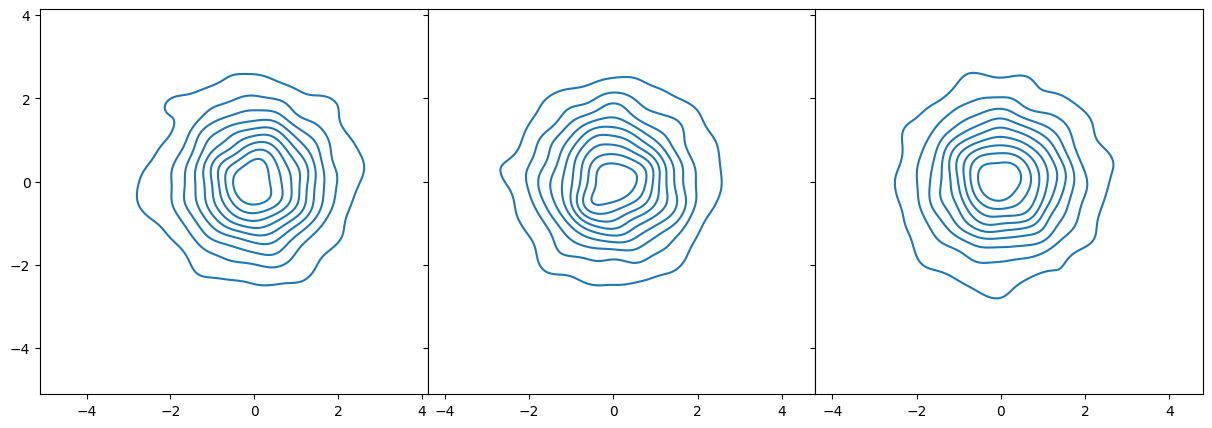

In [8]:
#### Training
# Evaluate latent space of the model in training set
z_train = nf_mctm.forward(y_train,train=False).detach().numpy()
res_normal_train, res_pval_train, z_mean_train, z_cov_train, p_train = evaluate_latent_space(z_train)
fig_train = plot_latent_space(z_train)

kl_divergence_nf_mctm_train = test_kl_divergence(model=nf_mctm,
                                                 test_data=y_train,
                                                 test_likelihood=train_likelihood)

#estimate true model on training data
est_mean = torch.mean(y_train,0)
est_cov = torch.cov(y_train.T)
y_distribution_est = MultivariateNormal(est_mean, est_cov)
train_likelihood_estimated_true_model = y_distribution_est.log_prob(y_test)
test_likelihood_estimated_true_model = y_distribution_est.log_prob(y_test)

kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
kl_divergence_true_model_train = kl_loss(train_likelihood, train_likelihood_estimated_true_model)

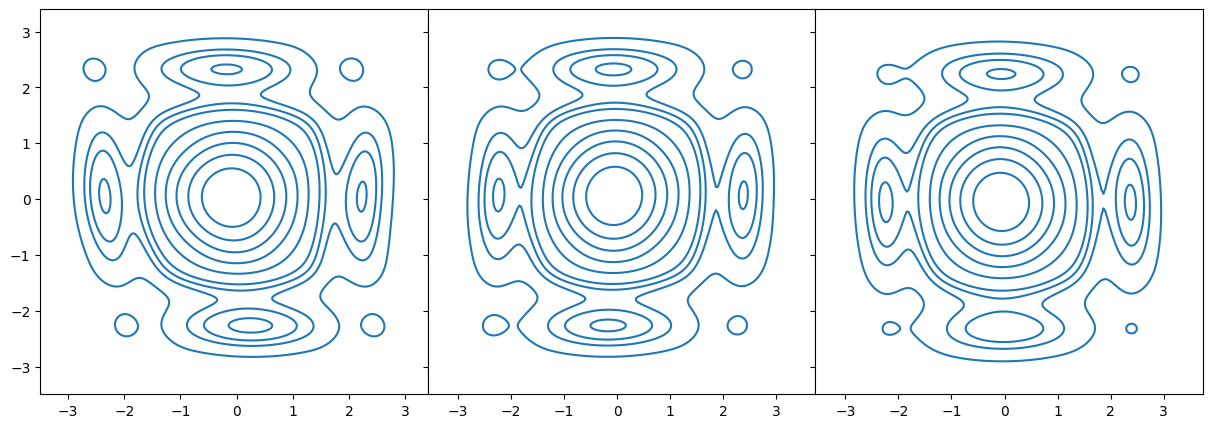

In [9]:
#### Test
# Evaluate latent space of the model in test set
z_test = nf_mctm.forward(y_test,train=False).detach().numpy()
res_normal_test, res_pval_test, z_mean_test, z_cov_test, p_test = evaluate_latent_space(z_test)
fig_test = plot_latent_space(z_test)

kl_divergence_nf_mctm_test = test_kl_divergence(model=nf_mctm,
                                   test_data=y_test,
                                   test_likelihood=test_likelihood)

kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
kl_divergence_true_model_test = kl_loss(test_likelihood, test_likelihood_estimated_true_model)

In [10]:
# Log Training Artifacts
model_info = mlflow.pytorch.log_model(nf_mctm, "nf_mctm_model")

np.save("loss_training_iterations.npy", loss_training_iterations)
mlflow.log_artifact("./loss_training_iterations.npy")

/opt/anaconda3/envs/mctm_pytorch_37/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [11]:
# Log Train Data Metrics and Artifacts
mlflow.log_metric("mv_normality_result_train",res_normal_train)
mlflow.log_metric("mv_normality_pval_train",res_pval_train)

np.save("z_mean_train.npy", z_mean_train)
mlflow.log_artifact("./z_mean_train.npy")

np.save("z_cov_train.npy", z_cov_train)
mlflow.log_artifact("./z_cov_train.npy")

np.save("uv_normality_pvals_train.npy", p_train)
mlflow.log_artifact("./uv_normality_pvals_train.npy")

fig_train.savefig('plot_latent_space_train.png')
mlflow.log_artifact("./plot_latent_space_train.png")

mlflow.log_metric("kl_divergence_nf_mctm_train",kl_divergence_nf_mctm_train)
mlflow.log_metric("kl_divergence_true_model_train",kl_divergence_true_model_train)

In [12]:
# Log Test Data Metrics and Artifacts
mlflow.log_metric("mv_normality_result_test",res_normal_test)
mlflow.log_metric("mv_normality_pval_train",res_pval_test)

np.save("z_mean_test.npy", z_mean_test)
mlflow.log_artifact("./z_mean_test.npy")

np.save("z_cov_test.npy", z_cov_test)
mlflow.log_artifact("./z_cov_test.npy")

np.save("uv_normality_pvals_test.npy", p_test)
mlflow.log_artifact("./uv_normality_pvals_test.npy")

fig_test.savefig('plot_latent_space_test.png')
mlflow.log_artifact("./plot_latent_space_test.png")

mlflow.log_metric("kl_divergence_nf_mctm_test",kl_divergence_nf_mctm_test)
mlflow.log_metric("kl_divergence_true_model_test",kl_divergence_true_model_test)

In [13]:
mlflow.end_run()

In [6]:
import pandas as pd
import torch
seed_value=1

In [10]:
int(seed_value)

1

In [19]:
torch.tensor(pd.read_csv("simulation_study_data/joe_3_2000/" + str(seed_value) + "_est_train_log_likelihoods.csv").values).flatten().size()

torch.Size([1999])

In [14]:
!mlflow ui

[2023-01-27 11:51:39 +0100] [8607] [INFO] Starting gunicorn 20.1.0
[2023-01-27 11:51:39 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:39 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:40 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:40 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:41 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:41 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:42 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:42 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:43 +0100] [8607] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-01-27 11:51:43 +0100] [8607] [ERROR] Retrying in 1 second.
[2023-01-27 11:51:44 +0100] [8607] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.


In [14]:
sns.scatterplot(x=z_train[0,:], y=z_train[1,:],alpha=0.6,color="k")
sns.kdeplot(x=z_train[0,:], y=z_train[1,:], fill=True, alpha=0.6, levels=5)
plt.show()